In [1]:
from datasets import generate_x_y_data_v1 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(10, 3, 2)
(10, 3, 2)
(seq_length, batch_size, output_dim)


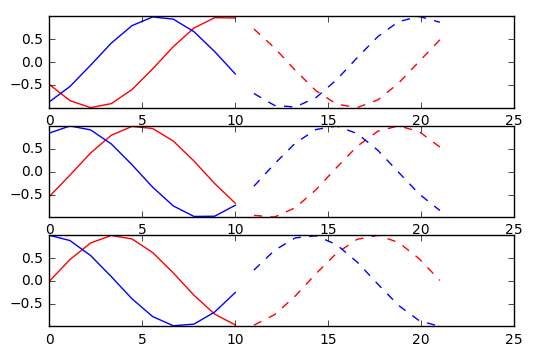

In [3]:
import math

plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
    plt.plot(x_axis+11, sample_y[:, i, 0], 'r--', x_axis+11, sample_y[:, i, 1], 'b--')

plt.show()

In [4]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[1]
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 12  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 1

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 150
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [5]:
test_encoder = Encoder(input_dim, hidden_dim, number_of_layers=layers_stacked_count)

# initialize the hidden state(num_layers, batch_size, hidden_size).
hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))

sample_x, sample_y = generate_data(isTrain=True, batch_size=batch_size)
input_x = autograd.Variable(torch.FloatTensor(sample_x), requires_grad=False)

print(test_encoder)

Encoder (
  (encoder): LSTM(2, 12, dropout=0.5)
)


In [6]:
encoder_output, encoder_state = test_encoder(input_x,hidden)
print(encoder_output[-1])

Variable containing:

Columns 0 to 9 
-0.1563 -0.0368 -0.0639  0.1699  0.0795 -0.0167  0.1002 -0.0037 -0.0758  0.0415
-0.1424 -0.0306 -0.1157  0.1612  0.0793 -0.0184  0.0739 -0.0053 -0.0615  0.0428
 0.0252  0.2444 -0.1542  0.0559 -0.1467  0.1369 -0.0549  0.0267  0.1965 -0.0644
 0.1183  0.2078 -0.0215  0.0790 -0.1900  0.1339  0.0514  0.0476  0.0526 -0.0737
-0.0653  0.1616 -0.1911  0.0895 -0.0394  0.0885 -0.0390  0.0158  0.1531 -0.0184

Columns 10 to 11 
-0.0645  0.0090
-0.0660  0.0065
-0.0028 -0.0969
-0.0633 -0.1468
-0.0095 -0.0441
[torch.FloatTensor of size 5x12]



In [7]:
test_decoder = Decoder(hidden_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count)
print(test_decoder)

Decoder (
  (decoder): LSTM(12, 12, dropout=0.5)
  (linear): Linear (12 -> 2)
)


In [8]:
decoder_input = torch.unsqueeze(encoder_output[-1], 0)
print(decoder_input.size())
decoder_hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))
test_output, decoder_output, (next_ht, next_ct) = test_decoder(decoder_input, decoder_hidden)
print(next_ht.size())
print(next_ct.size())
print(decoder_output.size())
print(test_output)

torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
Variable containing:
-0.0578  0.0316
-0.3574  0.2123
-0.3384  0.0072
 0.1305 -0.0272
-0.0121  0.3089
[torch.FloatTensor of size 5x2]



In [50]:
class Model(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 output_size,
                 number_of_layers=1,
                 output_length=10):
        super(Model, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, number_of_layers=number_of_layers)
        self.decoder = Decoder(hidden_size, hidden_size, output_size, number_of_layers=number_of_layers)
        self.output_length = output_length
        self.number_of_layers = number_of_layers
        self.hidden_size = hidden_size
        
    def forward(self, x):
        encoder_output, encoder_state = self.encoder(x, None)
        decoder_input = torch.unsqueeze(encoder_output[-1], 0)
        
        seq = []
        next_input = decoder_input
        next_hidden = None
        for _ in range(self.output_length):
            output, next_input, next_hidden = self.decoder(next_input, next_hidden)
            seq += [output]
        return torch.stack(seq, dim=0).squeeze(), decoder_hidden

In [51]:
model = Model(input_dim, 2, output_dim)
print(model)
test_output, final_hidden = model(input_x)
print(final_hidden[0].size())
print(test_output.size())

Model (
  (encoder): Encoder (
    (encoder): LSTM(2, 2, dropout=0.5)
  )
  (decoder): Decoder (
    (decoder): LSTM(2, 2, dropout=0.5)
    (linear): Linear (2 -> 2)
  )
)
torch.Size([1, 5, 12])
torch.Size([10, 5, 2])


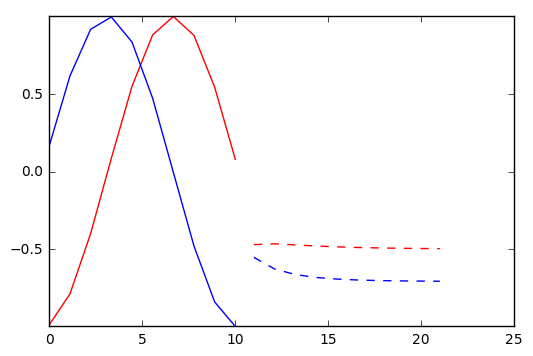

In [52]:
plot_y = test_output.data.numpy()
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
target_x = x_axis+11
plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
plt.show()

In [53]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
next_hidden = None

loss: 0.849795


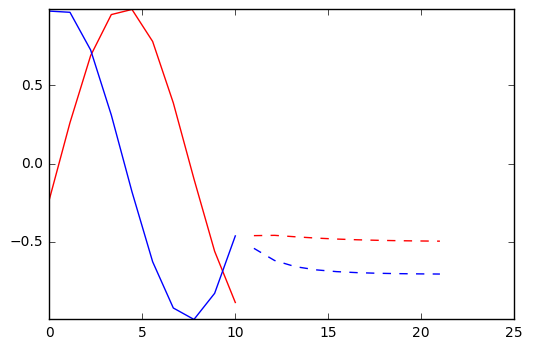

loss: 0.504163


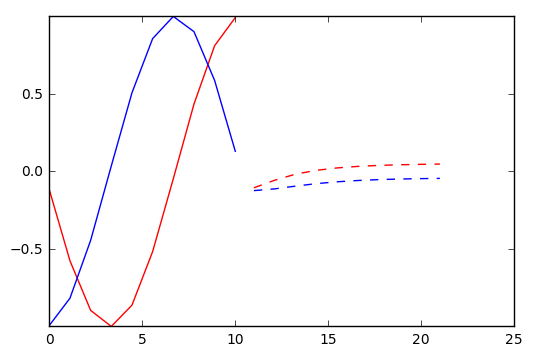

loss: 0.478929


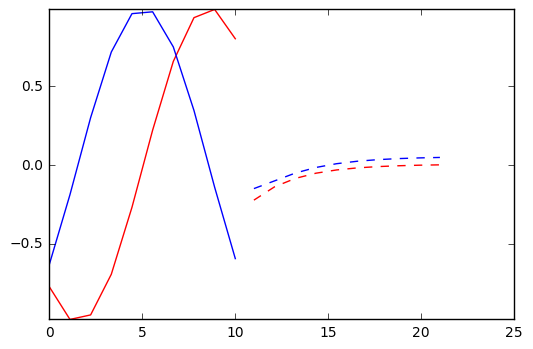

In [54]:
for step in range(nb_iters):
    temp_x, temp_y = generate_data(isTrain=True, batch_size=batch_size)
    x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
    y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
    optimizer.zero_grad()
    prediction, next_hidden = model(x)   # rnn output
    loss = loss_func(prediction, y)
    if step % 50 == 0:
        print('loss:', loss.data.numpy()[0])
        plot_y = prediction.data.numpy()
        plt.figure()
        plt.yticks(np.linspace(-1,1,5))
        plt.plot(x_axis, temp_x[:, i, 0], 'r', x_axis, temp_x[:, i, 1], 'b')
        plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
        plt.show()
    loss.backward()
    optimizer.step()

In [55]:
test_x, target_y = generate_data(isTrain=False, batch_size=5)
prediction, next_hidden = model(x)
prediction = prediction.data.numpy()
print(prediction.shape)
print(np.sum(target_y-prediction))

(10, 5, 2)
3.18551934824


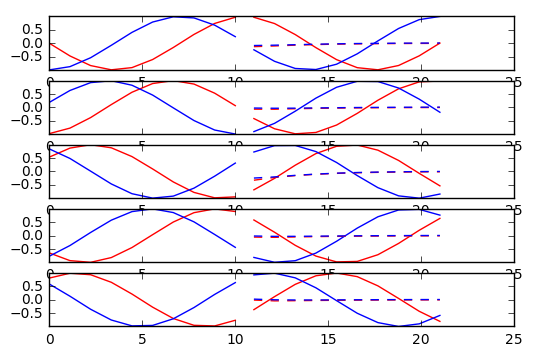

In [56]:
plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(5):
    plt.subplot(511+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, test_x[:, i, 0], 'r', x_axis, test_x[:, i, 1], 'b')
    target_x = x_axis+11
    
    plt.plot(target_x, target_y[:, i, 0], 'r', target_x, target_y[:, i, 1], 'b')
    plt.plot(target_x, prediction[:, i, 0], 'r--', target_x, prediction[:, i, 1], 'b--')

plt.show()